In [3]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Qiskit for pulse 
from qiskit import pulse
from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from qiskit import IBMQ
IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

In [6]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [7]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [8]:

num_qubits = 7

# Adjacency matrix 
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

In [30]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1: int, q2: int):
    """Retrieve the cross resonance pulse channel and waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2) # extract the cx pulse (q1 as control and q2 as target)
    cx1 = cx_pulse_instructions(q2, q1) # extract the cx pulse (q2 as control and q1 as target)
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # compare the period of the cx pulse
        cx = cx1 
    idx = 0 # index initializes to be 0
    Dr_gs = [] 
    cr_gs = [] 
    control_channel = ''
    Drive_Channel = ''
    another_Drive_Channel = ''
    #look for first Play instruction on a ControlChannel
    N = 1 
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N = 0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel



def Get_Shift_phase_CRTL_Chan(q1: int, q2: int):
    """Get q1 and q2 corresponding control channel so we can also rotate the corresponding control channel
    
    Args:
      q1: small one
      qt: target qubit index
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break
    return control_chan0, control_chan1


# CZ_gate pulse construction
def CZ_gate_schedule_3 (q0: int, q1: int):
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions # get Y 90 pulse
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse # get X 180 pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    CZ_schedule = pulse.Schedule(name="CZ gate pulse") 
    
    CZ_schedule |= Play(Y_pulse, Dchan)
    
    CZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    CZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    CZ_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    CZ_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    CZ_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    CZ_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)
    
    CZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        CZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*cr_samples+2*drive_samples)

    CZ_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)

    CZ_schedule |= ShiftPhase(-math.pi/2, Dchan) << int(2*cr_samples+3*drive_samples)
    
    for chan in control_chan1: 
        CZ_schedule |= ShiftPhase(-math.pi/2, chan) << int(2*cr_samples+3*drive_samples)
    
    CZ_schedule |= ShiftPhase(math.pi/2, another_Dchan) << int(2*cr_samples+3*drive_samples)
    
    for chan in control_chan0: 
        CZ_schedule |= ShiftPhase(math.pi/2, chan) << int(2*cr_samples+3*drive_samples)

    return CZ_schedule



In [31]:
class Graph_state:
    def __init__(self, backend, edges_list, tot_qubit = None):
        """
        The edge list is used to save edges, the connections between the qubits

        tot_qubit: the total number of qubits to create the graph state

        backend: the backend you use
        """
        self.edges_list = edges_list
        self.config = backend.configuration()

        if tot_qubit == None:
          self.tot_q = self.config.n_qubits
        else:
          self.tot_q = tot_qubit

        if self.config.n_qubits <  self.tot_q:
            
            raise Exception('Total qubits should not exceed {}.'.format(self.config.n_qubits))
            
        for x in self.edges_list:
            
            if list(x) not in backend_config.coupling_map:
                
                raise Exception('{} is not the backend.'.format(config.n_qubits))
        
    def Creat_graph_state_circuit(self):
        
        graph_circuit = QuantumCircuit(self.tot_q)  

        graph_circuit.h(range(self.tot_q))  

        for i in self.edges_list:        
            graph_circuit.cz(i[0],i[1])       

        return graph_circuit

In [32]:
def create_graph_state():
    
    
    edges_list = [(4,5), (1,3), (1,2), (3,5), (0,1), (5,6)]   # The combination we try and get the best result

    #edges_list = [(0,1), (5,6), (1,2), (3,5), (4,5), (1,3)] # The combination we try near the end of March and get the best result.

    graph_state = Graph_state( backend, edges_list)   

    graph_state_circuit = graph_state.Creat_graph_state_circuit()   

    return graph_state_circuit

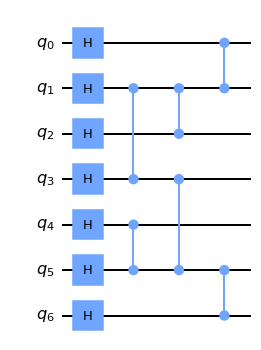

In [33]:
state_circuit = create_graph_state()
state_circuit.draw(output = "mpl")

In [34]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer,  initial_circuit=None, cz_pulse=False):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)

    if cz_pulse == True: #Add our custom CZ gate
        
        circ.add_calibration('cz', [1,2], CZ_gate_schedule_3(1,2))

        circ.add_calibration('cz', [0,1], CZ_gate_schedule_3(0,1))

        circ.add_calibration('cz', [3,5], CZ_gate_schedule_3(3,5))

        circ.add_calibration('cz', [1,3], CZ_gate_schedule_3(1,3))

        circ.add_calibration('cz', [4,5], CZ_gate_schedule_3(4,5))

        circ.add_calibration('cz', [5,6], CZ_gate_schedule_3(5,6))

        circ = transpile(circ, backend)
        
    circ.measure_all()
    return circ

In [18]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

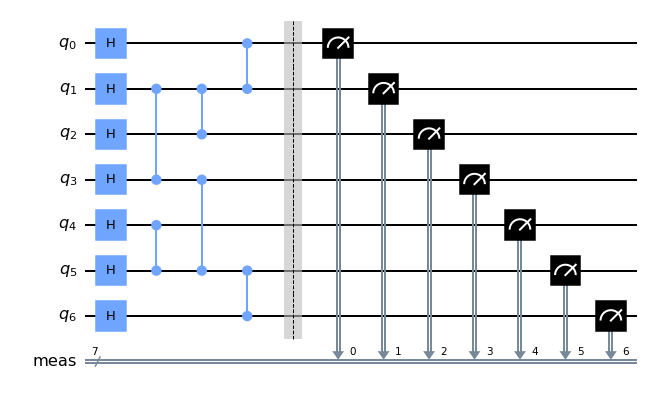

In [36]:
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)  # Default one is no our custom CZ addition. If one want to add our custom CZ gates,
                       for stab in stabilizers]                         # one need to put cz_pulse = True on the last argument of stabilizer_measure_circuit. 

stabilizer_circuits[0].draw(output = "mpl")

In [20]:
labels = ['0000000', '0000011', '0000101',  
          '0001001', '0001010', '0001100', 
          '0010001', '0010010', '0010100', '0011000', 
          '0100001', '0100010', '0100100', '0101000', '0110000', 
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
          '1111111'] 

qr = QuantumRegister(7)

qubit_list = [0,1,2,3,4,5,6]
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels) #  The CTMP method


meas_calibs1, metadata1 =  mit.expval_meas_mitigator_circuits(num_qubits,  method = 'complete') # complete method: a precise way to do error mitigation 


meas_calibs2, metadata2 =  mit.expval_meas_mitigator_circuits(num_qubits, method = 'tensored') # Tensor product method which will cause overestimated fidelity

In [21]:
reps = 4

In [ ]:

all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6] 

    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)


    # To get the best result of fidelity, one can use Tensored readout error mitigation.
    # If one want to get precise result, one can use complete one or CTMP one.

    job_mit_backend = execute(meas_calibs1, backend, shots=shots, initial_layout=il)
    
    
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)
    
    
    
    

Job IDs (1/4): 
 measurement calibration: 603d02547a77b10fb63e868c
 stabilizer measurements: 603d0250e1ef57ca71cade06
Job IDs (2/4): 
 measurement calibration: 603d02a5e1ef574761cade0b
 stabilizer measurements: 603d02a2badec22b24aecfc9
Job IDs (3/4): 
 measurement calibration: 603d02eb4365987ab2f08f1f
 stabilizer measurements: 603d02e89f4bdd03cd0f8285
Job IDs (4/4): 
 measurement calibration: 603d032e11e34038742e7194
 stabilizer measurements: 603d032a9f4bddf4760f8289


In [24]:

for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [25]:

result_backend = []
result_mit_backend = []
for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

In [26]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

In [27]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""
    
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [28]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata1).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

In [29]:
#Show the fidelity result

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('{:.3f} \u00B1 {:.3f}'.format(
     np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nComplete error mitigation')
print('{:.3f} \u00B1 {:.3f}'.format(
     np.mean(F_mit_backend), np.std(F_mit_backend)))

Graph-state fidelity estimates

No mitigation
0.721 ± 0.005

Complete error mitigation
0.972 ± 0.060
